In [28]:
import pandas as pd
from os import path
import os

#DATA_IN = "../../data/raw/semi-raw_data.csv"
DATA_IN = "../../data/raw/Jefferson_County_KY_Signalized_Intersections.csv"
assert path.exists(DATA_IN)

In [29]:

pwd = os.getcwd
pwd()

'/Users/bencampbell/code/no_traffic_lights/code/stoplights'

# Data Dictionary

|column name | dtype | type | description | value notes | cleaning notes |
|------------|-------|------|-------------|-------------|----------------|
|X|float|float | Longitude coordinate of approximate location for stoplight | | keep |
|Y|float|float | Latitude coordinate of approximate location for stoplight | | keep |
|OBJECTID|int64|int| Unique id for each stoplight | index | keep |
|UNITID|object|alphanumeric|d| not all unique 1088 vs 1091 total records | |
|SIGID|object| | | not all unique: ~ 1070 |c|
|MAINSTREET|object|string| Name of main street | ~366 unique | keep; very important |
|CROSSSTREE|object| string | Name of cross street |~450 unique: more than main street | keep; fix name |
|OWNER|object|string| | 'KYTC', 'METRO', 'JEFFERSONTOWN', 'MIDDLETOWN' | keep |
|OWNER2|object| string | | 'S', 'M', 'JT', 'MT' | duplicate? shortcode for OWNER? |
|ROUTE|object|alphanumeric| Alphanumeric designator for roadway like KY-123 US-123 | some null | keep |
|MILEPOINT|float64| float | Milepoint along roadway | some null | keep |
|DESCRIPTIO|object|string| Compact string description of intersection: MAINSTREET @ CROSSTREE(T) | redundant? | probably discard but maybe useful if its not clear what ROUTE means |
|TIMES|object|string| Appears to be a description of the operating hours for that light | Most are different versions of "24 hours", one is ACTUATED, some null | probably can ignore unless ACTUATED value is interesting|
|TYPE|object|int| No idea | 1, 2, 3, 4. Most values are 1, no clear pattern | figure out what this means. Is it tied to UNITID or SIGID? |
|INTID|object| | Intersection ID? | ~1048 unique: cross reference with DESCRIPTIO(N), SIGID, etc | probably a good index |
|ATMSID|float64||No idea|Most values are null/nan. Only one non null value. See below | probably drop. Maybe that record is interesting? times value is none|
| | | | || |
|geometry|geometry|POINT(Longitude, Latitude)| Approximate latitude, longitude coordinates of the intersection ||keep|

RANDOM NOTE: Ever notice how similar are ACTUATED and ACTIVATED semantically and graphically? cf Roman V vs U. VVEIRD STUFF

In [31]:
df = pd.read_csv(DATA_IN, index_col=0).reset_index()
df.head()

,X,Y,OBJECTID,UNITID,SIGID,MAINSTREET,CROSSSTREET,OWNER2,ROUTE,MILEPOINT,DESCRIPTION,TIMES,OWNER,TYPE,INTID,ATMSID
0,-85.499337,38.270632,1,MPW017206,SIG017206,OLD HENRY,I 265 RAMP,S,KY-3084,1.250,OLD HENRY @ I 265 RAMP,24 HOURS,KYTC,1,76747569996,NaN
1,-85.498479,38.241589,2,MPW017211,SIG017211,SHELBYVILLE,BECKLEY WOODS,S,US 60,12.291,SHELBYVILLE @ BECKLEY WOODS,24 HOURS,KYTC,1,78959406728,NaN
2,-85.493550,38.240517,3,MPW017290,SIG017290,SHELBYVILLE,LAKE FOREST,S,US-60,12.580,SHELBYVILLE @ LAKE FOREST,24 HOURS,KYTC,1,123759407630,NaN
3,-85.570212,38.311002,4,MPW015159,SIG015159,BROWNSBORO,I 265 RAMP,S,KY-22,3.700,BROWNSBORO @ I 265 RAMP,24 HOURS,KYTC,1,143907249996,NaN
4,-85.627965,38.283916,5,MPW011726,SIG011726,HERR,LIME KILN,S,KY-22,0.440,HERR @ LIME KILN,24 HOURS,KYTC,1,184229013860,NaN


In [32]:
# X Y 
df["X"]

0      -85.499337
1      -85.498479
2      -85.493550
3      -85.570212
4      -85.627965
          ...    
1086   -85.546671
1087   -85.495722
1088   -85.551047
1089   -85.614517
1090   -85.697942
Name: X, Length: 1091, dtype: float64

### UNITID SIGID columns

In [4]:
idgroup1 = df.groupby(['UNITID', 'SIGID'])
idgroup1.size()


UNITID     SIGID    
MPW000001  SIG000001    1
MPW000002  SIG000002    1
MPW000003  SIG000003    1
MPW000004  SIG000004    1
MPW000076  SIG000076    1
                       ..
MPW018044  SIG006911    1
MPW031109  SIG031109    1
MPW031240  SIG031240    1
MPW031241  SIG031241    1
MPW031242  SIG031242    1
Length: 1089, dtype: int64

In [5]:
result = idgroup1.size()
result[result.values > 1]

UNITID     SIGID    
MPW005889  SIG005889    2
MPW014474  SIG014474    2
dtype: int64

In [6]:
q = result[result.values > 1]
unit_ids = dupes = [x for x, _ in q.index]
q_result = df[df.UNITID.isin(unit_ids)]
q_result[['UNITID', 'SIGID', "INTID"]]

,UNITID,SIGID,INTID
X,,,
-85.753279,MPW005889,SIG005889,1338307075785
-85.578909,MPW014474,SIG014474,11343D281D284
-85.753542,MPW005889,SIG005889,1676242145872
-85.608664,MPW014474,SIG014474,433648057132


In [7]:
assert df.UNITID.str.startswith("MPW").all()
assert df.SIGID.str.startswith("SIG").all()

mismatch = df[df.UNITID.str.lstrip("MPW") != df.SIGID.str.lstrip("SIG")]
mismatch.TYPE.value_counts() # == 27
# Dope. 

#df[(df.TYPE != 2) & (df.OWNER == 'KYTC')] 
# but not
#df[(df.TYPE == 2) & (df.OWNER != 'KYTC')] 

df[(df.TYPE != 2)].OWNER.value_counts()
df[df.OWNER == 'KYTC'].TYPE.value_counts()

# What does it mean?


TYPE
1    707
2     27
3     17
Name: count, dtype: int64

In [8]:
match = df[df.UNITID.str.lstrip("MPW") == df.SIGID.str.lstrip("SIG")]
match.TYPE.value_counts() # No values equal 2. That is good news.


TYPE
1    1018
3      44
4       2
Name: count, dtype: int64

IMPORTANT Relationship: TYPE == 2 implies OWNER == KYTC and ID mismatch

In [9]:
type4 = match[match.TYPE == 4]
type4[type4.UNITID != type4.SIGID]

,Y,OBJECTID,UNITID,SIGID,MAINSTREET,CROSSSTREET,OWNER2,ROUTE,MILEPOINT,DESCRIPTION,TIMES,OWNER,TYPE,INTID,ATMSID
X,,,,,,,,,,,,,,,
-85.783658,38.245065,1032,MPW004166,SIG004166,BRECKINRIDGE,DIXIE,M,NaN,NaN,BRECKINRIDGE @ DIXIE,ACTUATED,METRO,4,1312806581612,NaN
-85.729228,38.249384,1057,MPW006925,SIG006925,COOPER,LEXINGTON,M,NaN,NaN,COOPER @ LEXINGTON,24 HOURS,METRO,4,1553912713838,NaN


In [10]:
# MAINSTREET CROSSSTREET
# Compare DESCRIPTIO(N)


In [11]:
# OWNER OWNER2
df[['OWNER', 'OWNER2']].value_counts()
# All of these line up one to one. I will drop OWNER2 because it is less readable.

OWNER          OWNER2
KYTC           S         751
METRO          M         334
JEFFERSONTOWN  JT          5
MIDDLETOWN     MT          1
Name: count, dtype: int64

In [12]:
# ROUTE

In [13]:
# MILEPOINT
MP = df.MILEPOINT.dropna()
MP.describe()

count    734.000000
mean       8.191883
std        5.913058
min        0.000000
25%        3.032500
50%        7.445000
75%       12.294000
max       22.035000
Name: MILEPOINT, dtype: float64

MILEPOINT
0.000     10
16.185     5
5.180      4
3.800      3
2.000      3
          ..
7.560      1
2.670      1
10.800     1
15.130     1
6.470      1
Name: count, Length: 666, dtype: int64

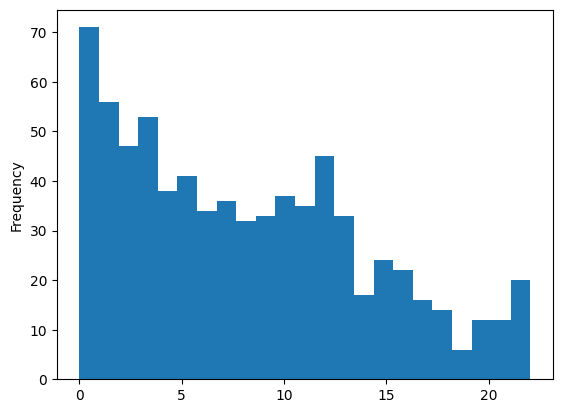

In [14]:
import math 

total = len(MP)
maxi = math.ceil(MP.values.max())
mini = math.floor(MP.values.min())
bins = abs(mini) + maxi

MP.plot.hist(bins=bins)
# Is 0 a default value?
MP.value_counts()


In [15]:
# TIMES
df.TIMES.value_counts()
new = df.TIMES.replace(
    {"24 HOUR":"24 HOURS",
     "24HRS":"24 HOURS"})
df.TIMES = new
df.TIMES.value_counts()
# Dope, that works

TIMES
24 HOURS    1089
ACTUATED       1
Name: count, dtype: int64

In [16]:
df[df.TIMES=='ACTUATED']

,Y,OBJECTID,UNITID,SIGID,MAINSTREET,CROSSSTREET,OWNER2,ROUTE,MILEPOINT,DESCRIPTION,TIMES,OWNER,TYPE,INTID,ATMSID
X,,,,,,,,,,,,,,,
-85.783658,38.245065,1032,MPW004166,SIG004166,BRECKINRIDGE,DIXIE,M,NaN,NaN,BRECKINRIDGE @ DIXIE,ACTUATED,METRO,4,1312806581612,NaN


# TYPE column


#### Figuring out TYPE

In [17]:
# TYPE
df.TYPE.value_counts()


TYPE
1    1018
3      44
2      27
4       2
Name: count, dtype: int64

In [18]:
df[['OWNER', 'TYPE']].value_counts()
# Nope. That didn't work

OWNER          TYPE
KYTC           1       707
METRO          1       305
KYTC           2        27
METRO          3        27
KYTC           3        17
JEFFERSONTOWN  1         5
METRO          4         2
MIDDLETOWN     1         1
Name: count, dtype: int64

In [19]:
display(dupes) # Just a hunch. These don't match at all though so it was a bad hunch.
type4 = df[df.TYPE == 4]
type4['OWNER'].value_counts()
# All values == METRO

['MPW005889', 'MPW014474']

OWNER
METRO    2
Name: count, dtype: int64

In [20]:
type3 = df[df.TYPE == 3]
type3['OWNER'].value_counts()

OWNER
METRO    27
KYTC     17
Name: count, dtype: int64

In [21]:
df[['OWNER', 'TYPE']].value_counts()
# Nope. That didn't work
# ...but it DID work. Use up top: OWNER:KYTC, TYPE:2 <- count == 27

OWNER          TYPE
KYTC           1       707
METRO          1       305
KYTC           2        27
METRO          3        27
KYTC           3        17
JEFFERSONTOWN  1         5
METRO          4         2
MIDDLETOWN     1         1
Name: count, dtype: int64

In [22]:
df[df.TYPE==2]['OWNER'].value_counts()
# all TYPE==2 :: OWNER == KYTC

OWNER
KYTC    27
Name: count, dtype: int64

In [23]:
df[df.TYPE==1]['OWNER'].value_counts()

OWNER
KYTC             707
METRO            305
JEFFERSONTOWN      5
MIDDLETOWN         1
Name: count, dtype: int64

In [24]:
pd.concat({n:df[df.TYPE == n]['OWNER'].value_counts() for n in (1,2,3,4)}, axis=1)

,1,2,3,4
OWNER,,,,
KYTC,707,27.0,17.0,NaN
METRO,305,NaN,27.0,2.0
JEFFERSONTOWN,5,NaN,NaN,NaN
MIDDLETOWN,1,NaN,NaN,NaN
